<a href="https://colab.research.google.com/github/Haebuk/kuggle/blob/main/gamestop_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer
from sklearn.model_selection import train_test_split

PATH = '/content/drive/MyDrive/input/'
df = pd.read_csv(PATH + 'GME_scaled.csv')

hpo_configs = {
    'learning_rate': 0.008706356110059394,
    'dropout_rate1': 0.24704916015588443,
    'hidden1': 38,
    'time_step': 1,
}

X = df.drop('date', axis=1).values
y = df['open_price'].values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=False)

time_step = hpo_configs['time_step']
X_train, y_train, X_test, y_test = [], [], [], []
for i in range(time_step,len(X_tr)): # train
    X_train.append(X_tr[i-time_step:i,:])
    y_train.append(y_tr[i])
for i in range(time_step, len(X_te)): # test
    X_test.append(X_te[i-time_step:i,:])
    y_test.append(y_te[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
# LSTM input shape 조건(batch_size, timestep, feature_num)에 맞게 reshape
X_train = np.reshape(X_train, (-1,X_train.shape[1],2))
X_test = np.reshape(X_test, (-1,X_test.shape[1],2))

model = tf.keras.Sequential([
InputLayer(input_shape=(hpo_configs['time_step'], 2)),
LSTM(hpo_configs['hidden1']),
Dropout(hpo_configs['dropout_rate1']),
Dense(1),
])

opt = tf.keras.optimizers.Adam(learning_rate=hpo_configs['learning_rate'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'best-model-weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

model.compile(optimizer=opt,
            loss='mse')

model.fit(X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200, callbacks=[early_stopping, checkpoint])

Epoch 1/200
82/82 [==============================] - 2s 7ms/step - loss: 1.3182 - val_loss: 0.5540

Epoch 00001: val_loss improved from inf to 0.55399, saving model to best-model-weights.h5
Epoch 2/200
82/82 [==============================] - 0s 3ms/step - loss: 0.1621 - val_loss: 0.3241

Epoch 00002: val_loss improved from 0.55399 to 0.32412, saving model to best-model-weights.h5
Epoch 3/200
82/82 [==============================] - 0s 3ms/step - loss: 0.1229 - val_loss: 0.1399

Epoch 00003: val_loss improved from 0.32412 to 0.13993, saving model to best-model-weights.h5
Epoch 4/200
82/82 [==============================] - 0s 3ms/step - loss: 0.0980 - val_loss: 0.1811

Epoch 00004: val_loss did not improve from 0.13993
Epoch 5/200
82/82 [==============================] - 0s 3ms/step - loss: 0.0853 - val_loss: 0.0854

Epoch 00005: val_loss improved from 0.13993 to 0.08543, saving model to best-model-weights.h5
Epoch 6/200
82/82 [==============================] - 0s 3ms/step - loss: 0.08

In [119]:
model.load_weights('best-model-weights.h5')

In [120]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 38)                6232      
_________________________________________________________________
dropout_5 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 39        
Total params: 6,271
Trainable params: 6,271
Non-trainable params: 0
_________________________________________________________________


# Inference

In [121]:
df_ag = pd.read_csv(PATH + 'gme_august.csv')
df_ag.head()

,date,open_price,volume
0,2021-08-02,5.093750,0.117547
1,2021-08-03,5.060948,1.000000
2,2021-08-04,5.035198,0.107225
3,2021-08-05,5.003946,0.108603
4,2021-08-06,5.047224,0.029818


In [122]:
X_ag= df_ag.drop('date', axis=1).values
y_ag = df_ag['open_price'].values


X_ag_test, y_ag_test = [], []
for i in range(time_step,len(X_ag)): # train
    X_ag_test.append(X_ag[i-time_step:i,:])
    y_ag_test.append(y_ag[i])


X_ag_test, y_ag_test = np.array(X_ag_test), np.array(y_ag_test)
X_ag_test = np.reshape(X_ag_test, (-1,X_ag_test.shape[1],2))

print(X_ag_test.shape, y_ag_test.shape)

(14, 1, 2) (14,)


In [123]:
pred = model.predict(X_ag_test)
pred

array([[5.13551  ],
       [5.4689   ],
       [5.078705 ],
       [5.0518003],
       [5.047939 ],
       [5.0677543],
       [5.095662 ],
       [5.0525494],
       [5.075429 ],
       [5.0661154],
       [5.091704 ],
       [5.078207 ],
       [5.0969715],
       [5.0538006]], dtype=float32)

In [124]:
len(X_ag)

15

In [125]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_ag_test, pred))

0.014570218929707602


In [126]:
open_price = pd.concat([df['open_price'], df_ag['open_price']], axis=0)
open_price = np.expm1(open_price).reset_index(drop=True)

In [127]:
pred_price = np.expm1(pred)

In [128]:
open_price[-15:]

2914    162.000000
2915    156.740005
2916    152.729996
2917    148.000000
2918    154.589996
2919    151.800003
2920    161.360001
2921    158.429993
2922    159.880005
2923    160.470001
2924    161.000000
2925    161.190002
2926    163.250000
2927    156.770004
2928    153.800003
Name: open_price, dtype: float64

In [129]:
pred_price[-15:]

array([[168.95096],
       [236.19917],
       [159.56596],
       [155.30359],
       [154.7012 ],
       [157.81726],
       [162.31194],
       [155.42073],
       [159.04083],
       [157.55719],
       [161.6668 ],
       [159.48605],
       [162.52592],
       [155.61658]], dtype=float32)

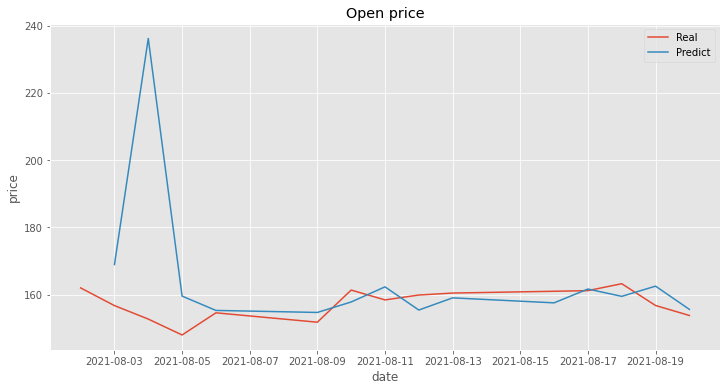

In [130]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df_ag['date'] = pd.to_datetime(df_ag['date'])
plt.figure(figsize=(12, 6))
plt.plot(df_ag['date'], np.expm1(df_ag['open_price']), label='Real')
plt.plot(df_ag['date'][1:], pred_price, label='Predict')
plt.xlabel('date')
plt.ylabel('price')
plt.title('Open price')
plt.legend()